In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import os.path
from keras import layers
from keras import models
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

# Load dataset

In [ ]:
# Access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unrar x '/content/gdrive/MyDrive/Colab Notebooks/SceneClassificationData.rar'

Streaming output truncated to the last 5000 lines.
Extracting  SceneClassificationData/seg_train/street/12861.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12870.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12875.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12876.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12878.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12880.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12883.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12884.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12898.jpg            81%  OK 
Extracting  SceneClassificationData/seg_train/street/12917.jpg            81%  OK 
Extracting  SceneClassificati

# CNN

## Preprocess

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'SceneClassificationData/seg_train',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'SceneClassificationData/seg_validation',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'SceneClassificationData/seg_test/seg_test',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (32, 60, 60, 3)
labels batch shape: (32, 6)


## Model

In [ ]:
def design_model():
  # Architecture
  model = models.Sequential()
  ## convnet
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(60,60,3)))
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  model.add(layers.Conv2D(128, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  ## add a classifier on top
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(layers.Dense(6, activation='softmax'))


  # Compilation
  model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
model = design_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)        0

In [ ]:
# Training
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=50)
model.save('model.h5')

Epoch 1/25
100/100 [==============================] - 59s 548ms/step - loss: 1.5610 - accuracy: 0.3331 - val_loss: 1.3273 - val_accuracy: 0.4806
Epoch 2/25
100/100 [==============================] - 43s 430ms/step - loss: 1.2816 - accuracy: 0.4843 - val_loss: 1.2668 - val_accuracy: 0.5038
Epoch 3/25
100/100 [==============================] - 33s 329ms/step - loss: 1.1855 - accuracy: 0.5126 - val_loss: 1.0859 - val_accuracy: 0.5656
Epoch 4/25
100/100 [==============================] - 48s 477ms/step - loss: 1.0546 - accuracy: 0.5766 - val_loss: 1.0485 - val_accuracy: 0.5619
Epoch 5/25
100/100 [==============================] - 33s 332ms/step - loss: 1.0460 - accuracy: 0.5932 - val_loss: 0.9120 - val_accuracy: 0.6575
Epoch 6/25
100/100 [==============================] - 33s 329ms/step - loss: 0.9543 - accuracy: 0.6341 - val_loss: 0.9340 - val_accuracy: 0.6413
Epoch 7/25
100/100 [==============================] - 32s 324ms/step - loss: 0.9294 - accuracy: 0.6456 - val_loss: 0.8577 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Loss of testset (Cross Entropy):', test_loss)
print('Metric of testset (Accuracy):', test_acc)

94/94 [==============================] - 12s 133ms/step - loss: 0.6831 - accuracy: 0.7563
Loss of testset (Cross Entropy): 0.6830949187278748
Metric of testset (Accuracy): 0.7563333511352539


## Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

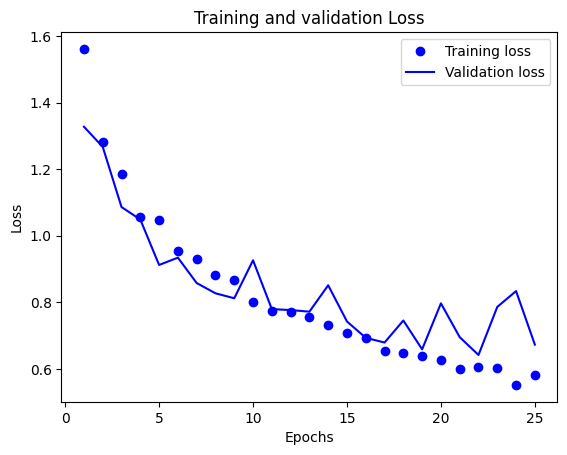

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

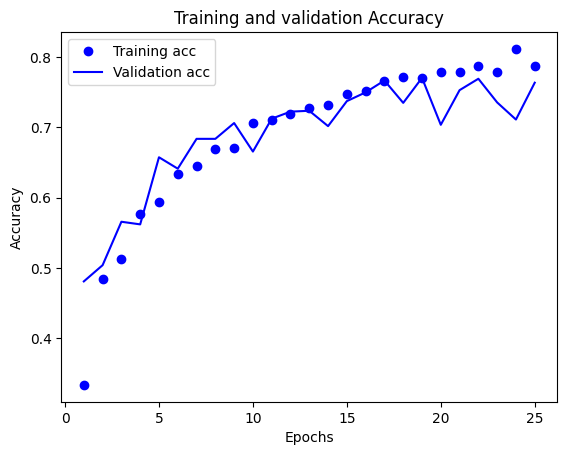

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**It seems that best epoch for this problem is 16**

## Prediction

In [ ]:
pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = pred_datagen.flow_from_directory(
    'SceneClassificationData/seg_pred',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

yhat = model.predict(pred_generator)

Found 7301 images belonging to 1 classes.
229/229 [==============================] - 27s 115ms/step


In [ ]:
predictions = []
for y in yhat:
  class_pred = np.argmax(y)
  predictions.append(class_pred)

# Data Augmentation

## Preprocess

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,0.8],
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    'SceneClassificationData/seg_train',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.


## Train

In [ ]:
# Compilation
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Training
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=50)
model.save('model_aug.h5')

Epoch 1/25
100/100 [==============================] - 40s 387ms/step - loss: 0.9172 - accuracy: 0.6672 - val_loss: 0.7623 - val_accuracy: 0.7531
Epoch 2/25
100/100 [==============================] - 37s 373ms/step - loss: 0.8403 - accuracy: 0.6884 - val_loss: 0.9303 - val_accuracy: 0.6706
Epoch 3/25
100/100 [==============================] - 37s 373ms/step - loss: 0.8180 - accuracy: 0.6981 - val_loss: 0.9162 - val_accuracy: 0.7194
Epoch 4/25
100/100 [==============================] - 37s 373ms/step - loss: 0.8099 - accuracy: 0.7044 - val_loss: 0.8069 - val_accuracy: 0.7375
Epoch 5/25
100/100 [==============================] - 38s 377ms/step - loss: 0.7850 - accuracy: 0.7169 - val_loss: 0.7629 - val_accuracy: 0.7506
Epoch 6/25
100/100 [==============================] - 37s 372ms/step - loss: 0.8366 - accuracy: 0.6966 - val_loss: 0.7096 - val_accuracy: 0.7619
Epoch 7/25
100/100 [==============================] - 36s 360ms/step - loss: 0.7579 - accuracy: 0.7234 - val_loss: 0.7356 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Loss of testset (Cross Entropy):', test_loss)
print('Metric of testset (Accuracy):', test_acc)

94/94 [==============================] - 15s 157ms/step - loss: 0.7666 - accuracy: 0.7337
Loss of testset (Cross Entropy): 0.7666396498680115
Metric of testset (Accuracy): 0.7336666584014893


## Plot

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

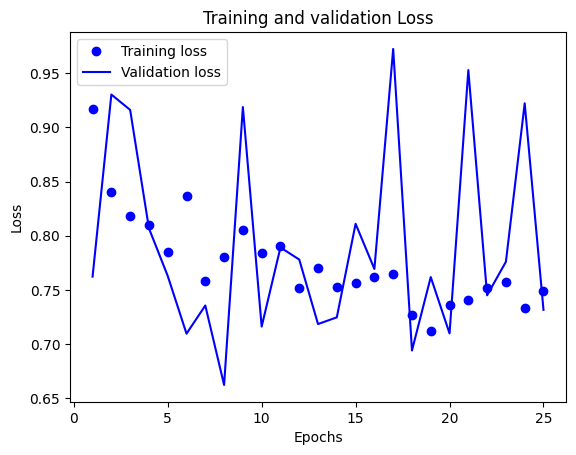

In [ ]:
# Plot training and validation Loss

train_loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(train_loss_values)+1)

plt.plot(epochs, train_loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

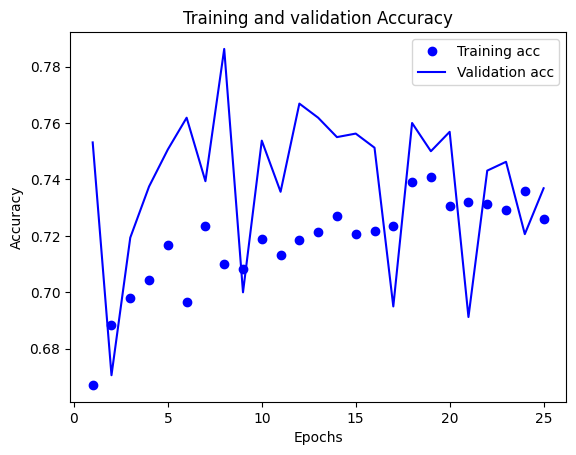

In [ ]:
# Plot training and validation Accuracy

train_acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(train_acc_values)+1)

plt.plot(epochs, train_acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Prediction

In [ ]:
pred_datagen_aug = ImageDataGenerator(rescale=1./255)

pred_generator_aug = pred_datagen_aug.flow_from_directory(
    'SceneClassificationData/seg_pred',
    target_size=(60, 60),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
)

yhat_aug = model.predict(pred_generator_aug)

Found 7301 images belonging to 1 classes.
229/229 [==============================] - 24s 104ms/step


In [ ]:
predictions_aug = []
for y in yhat_aug:
  class_pred = np.argmax(y)
  predictions_aug.append(class_pred)